In [1]:
import os
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pymongo
from tqdm import tqdm
from scipy import stats
import math
import numpy as np

In [2]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["imdb"]
imdb = db['imdb_cleaned']

In [3]:
num_movies = imdb.count_documents({})
num_movies

8181

In [4]:
runtime_arr = []
revenue_arr = []
budget_arr = []

for movie in imdb.find():
    runtime = movie['cleaned_Runtime_min']
    revenue = movie['cleaned_Revenue']
    budget = movie['cleaned_Budget']

    runtime_arr.append(runtime)
    revenue_arr.append(revenue)
    budget_arr.append(budget)

In [5]:
# xrr = [1,2,3,4,5,6]
# xrr = np.array(xrr)
# xrr = xrr/xrr.max()
# xrr

In [9]:
def min_maxScaling(arr):
    arr = np.array(arr)
    return (arr - arr.min())/(arr.max-arr.min())

In [ ]:
# runtime_arr = np.array(runtime_arr)
# revenue_arr = np.array(revenue_arr)
# budget_arr = np.array(budget_arr)

# runtime_arr = min_maxScaling(runtime_arr)
# revenue_arr = min_maxScaling

# Linear Regression -- runtime vs revenue

In [6]:
from scipy.stats import spearmanr

In [7]:
spearmanr(runtime_arr, revenue_arr)

SpearmanrResult(correlation=0.32575536020776497, pvalue=1.5683970770459886e-201)

In [8]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [14]:
runtime_x = sm.add_constant(runtime_arr)
model = sm.OLS(revenue_arr, runtime_x)
results = model.fit()

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     668.8
Date:                Fri, 21 May 2021   Prob (F-statistic):          8.09e-142
Time:                        21:58:45   Log-Likelihood:            -1.6807e+05
No. Observations:                8181   AIC:                         3.361e+05
Df Residuals:                    8179   BIC:                         3.362e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.345e+08   1.32e+07    -17.825      0.000    -2.6e+08   -2.09e+08
x1          3.154e+06   1.22e+05     25.861      0.000    2.92e+06    3.39e+06
==============================================================================
Omnibus:                     8306.177   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           666706.950
Skew:                           4.928   Prob(JB):                         0.00
Kurtosis:                      46.113   Cond. No.                         634.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
from statsmodels.stats.outliers_influence import summary_table

In [17]:
def plot_regression_line(results, xrr, yrr):

    st, data, ss2 = summary_table(results, alpha=0.05)

    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T

    fig = make_subplots()
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=yrr, 
            name="Data",
            mode='markers',
            line_color='rgba(153, 153, 255, .6)'
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=fittedvalues, 
            name="regression line",
            # mode='lines',
            # line_color='green'
            line=dict(color='green', width=3)
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=predict_ci_low, 
            name="95% prediction band",
            line=dict(color='rgba(153, 0, 51, .5)', width=1, dash='dot')
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=predict_ci_upp, 
            line=dict(color='rgba(153, 0, 51, .5)', width=1, dash='dot'),
            showlegend=False
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=predict_mean_ci_low, 
            name="95% prediction region",
            mode='lines',
            line=dict(color='rgba(0, 153, 51, .5)', width=1, dash='dot'),
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=predict_mean_ci_upp, 
            line=dict(color='rgba(0, 153, 51, .5)', width=1, dash='dot'),
            showlegend=False
        ),
    )

    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))
    fig.update_layout(
        height=600, 
        width=800,
    )
    # fig.update_layout(
    #     # margin=dict(l=10, r=10, t=10, b=10),
    #     paper_bgcolor="LightSteelBlue",
    # )
    fig.update_layout(
        title="Plot Title",
        xaxis_title="X Axis Title",
        yaxis_title="Y Axis Title",
        legend_title="Legend Title",
    )
    
    return fig

In [18]:
fig = plot_regression_line(results, runtime_arr, revenue_arr)
fig.show()

# Linear regression -- runtime vs budget

In [19]:
spearmanr(runtime_arr, budget_arr)

SpearmanrResult(correlation=0.37443168220226497, pvalue=1.2362435421348507e-270)

In [20]:
runtime_x = sm.add_constant(runtime_arr)
model = sm.OLS(budget_arr, runtime_x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     1075.
Date:                Fri, 21 May 2021   Prob (F-statistic):          1.24e-221
Time:                        21:59:06   Log-Likelihood:            -1.5536e+05
No. Observations:                8181   AIC:                         3.107e+05
Df Residuals:                    8179   BIC:                         3.107e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.291e+07   2.78e+06    -19.017      0.000   -5.84e+07   -4.75e+07
x1           8.46e+05   2.58e+04     32.787      0.000    7.95e+05    8.97e+05
==============================================================================
Omnibus:                     3674.982   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19617.998
Skew:                           2.141   Prob(JB):                         0.00
Kurtosis:                       9.262   Cond. No.                         634.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
fig = plot_regression_line(results, runtime_arr, budget_arr)
fig.show()

# Curve fit -- runtime vs revenue

In [16]:
def plotCurve(x, y, mymodel):
    fig = make_subplots()
    fig.add_trace(
        go.Scatter(
            x=x, 
            y=y, 
            name="Movies",
            mode='markers',
            line_color='rgba(153, 153, 255, .6)'
        ),
    )
    myline = np.linspace(1, x.max(), 100)
    fig.add_trace(
        go.Scatter(
            x=myline, 
            y=mymodel(myline), 
            name="regression curve",
            # mode='lines',
            # line_color='green'
            line=dict(color='green', width=3)
        ),
    )

    return fig

In [17]:
import numpy as np
from matplotlib import pyplot as plt

x = np.array(runtime_arr)
y = np.array(revenue_arr)
mymodel = np.poly1d(np.polyfit(x, y, 6))

from sklearn.metrics import r2_score
print(r2_score(y, mymodel(x)))

fig = plotCurve(x, y, mymodel)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600, 
    width=800,
)

fig.update_layout(
    # title="Plot Title",
    xaxis_title="Runtime",
    yaxis_title="Revenue",
    # legend_title="Legend Title",
)

fig.update_layout(
     margin=dict(l=10, r=10, t=10, b=10),
     # paper_bgcolor="LightSteelBlue",
)

fig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green",
)
fig.update_layout(font=dict(size=18))


fig.show()
# plt.scatter(x, y)
# plt.plot(myline, mymodel(myline))
# plt.show()

0.08614442432210179


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

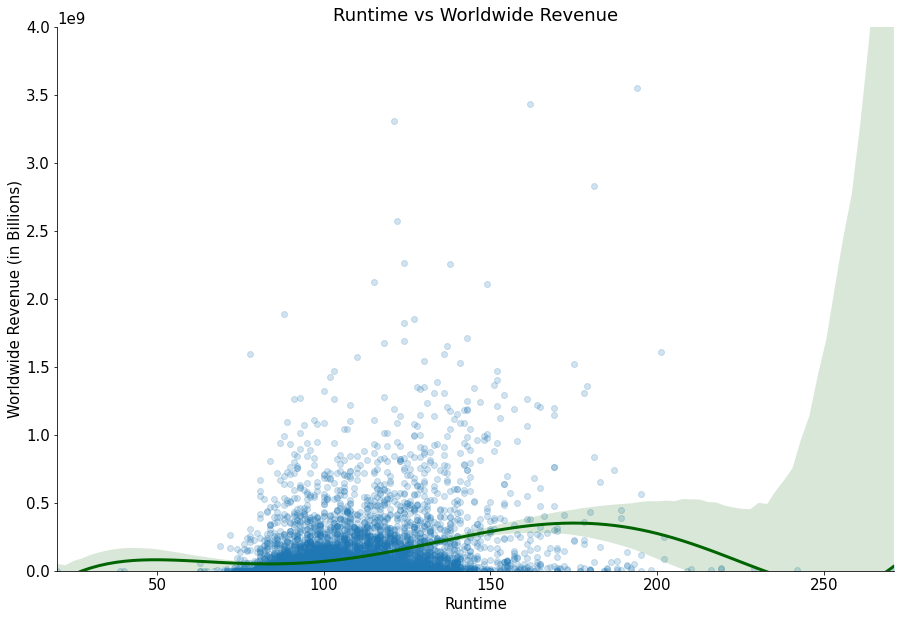

In [34]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15, 10))
sns.regplot(x = runtime_arr, y = revenue_arr, scatter_kws={'alpha':0.2}, line_kws={"color": "darkgreen", 'linewidth': 3}, order=6)
plt.title('Runtime vs Worldwide Revenue')          # Set title.
plt.xlabel("Runtime")       # Set x-axis label.
plt.ylabel('Worldwide Revenue (in Billions)')    # Set y-axis label.
plt.ylim(-3, 4*1e9)
sns.despine()
plt.savefig('runtime_vs_revenue.png')

# hoeffdingD assosiation

In [72]:
from  XtendedCorrel import hoeffding
import pandas as pd

In [130]:
def pdf(x):
    mean = np.mean(x)
    std = np.std(x)
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out

In [138]:
x = np.random.randint(70, size=2000)
# y = np.random.randint(70, size=2000)
y= pdf(x)
df=pd.DataFrame({ 'x': x, 'y': y } )
hoeffding(df)

x         y
x  0.947472  0.223976
y  0.223976  0.946434

In [139]:
hoeffding(x, y)

0.2239755922564421

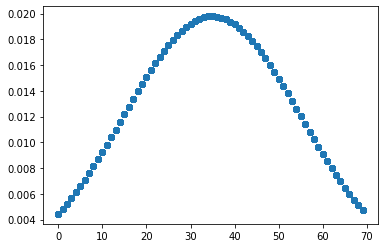

In [140]:
plt.scatter(x, pdf(x))
plt.show()

In [119]:
np.random.randint(70)

26

In [141]:
x = np.array(runtime_arr)
y = np.array(revenue_arr)
df=pd.DataFrame({ 'x': x, 'y': y } )
hoeffding(df)

x         y
x  0.940705  0.032732
y  0.032732  0.951030

# Curvefit

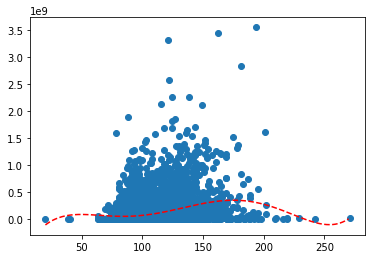

In [26]:
# fit a second degree polynomial to the economic data
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

# define the true objective function
def objective(x, a, b, c, d, e, f):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

# x = np.random.randint(70, size=2000)
# y = pdf(x)
x = np.array(runtime_arr)
y = np.array(revenue_arr)

popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d, e, f = popt
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e, f)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

In [37]:
def splitDataset(xrr, yrr, x_th):
    xrr1 = []
    yrr1 = []

    xrr2 = []
    yrr2 = []

    for i in range(len(xrr)):
        if(xrr[i] < th):
            xrr1.append(xrr[i])
            yrr1.append(yrr[i])
        else:
            xrr2.append(xrr[i])
            yrr2.append(yrr[i])

    return np.array(xrr1), np.array(yrr1), np.array(xrr2), np.array(yrr2)

# Double Regression

In [58]:
def plotRegression2(x, y, mymodel, fig):
    fig.add_trace(
        go.Scatter(
            x=x, 
            y=y, 
            name="Data",
            mode='markers',
            line_color='rgba(153, 153, 255, .6)'
        ),
    )
    xxrr = x.reshape(x.shape[0],1)
    fig.add_trace(
        go.Scatter(
            x=x, 
            y=mymodel.predict(xxrr), 
            name="regression line",
            # mode='lines',
            # line_color='green'
            line=dict(color='green', width=3)
        ),
    )

    return fig

In [59]:
fig = make_subplots()

In [60]:
spearmanr(runtime_arr, revenue_arr)

SpearmanrResult(correlation=0.32575536020776497, pvalue=1.5683970770459886e-201)

In [61]:
from sklearn.linear_model import LinearRegression

def getModel(xrr, yrr):
    xxrr = xrr.reshape(xrr.shape[0],1)
    model = LinearRegression()
    model.fit(xxrr, yrr)
    return model

In [66]:
th = 100

for th in range(40, 250, 10):
    xrr1, yrr1, xrr2, yrr2 = splitDataset(runtime_arr, revenue_arr, th)
    sr1 = spearmanr(xrr1, yrr1)
    sr2 = spearmanr(xrr2, yrr2)

    print('Threshold: {} --> up: corr {:.3f} p {:.3f} -- down corr {:.3f} p {:.3f}'.format(th, sr1.correlation, sr1.pvalue, sr2.correlation, sr2.pvalue))

    # model1 = getModel(xrr1, yrr1)
    # fig = make_subplots()
    # fig = plotRegression2(xrr1, yrr1, model1, fig)
    # fig.show()

Threshold: 40 --> up: corr -1.000 p nan -- down corr 0.325 p 0.000
Threshold: 50 --> up: corr 0.500 p 0.667 -- down corr 0.325 p 0.000
Threshold: 60 --> up: corr 0.500 p 0.667 -- down corr 0.325 p 0.000
Threshold: 70 --> up: corr 0.339 p 0.282 -- down corr 0.324 p 0.000
Threshold: 80 --> up: corr 0.090 p 0.287 -- down corr 0.316 p 0.000
Threshold: 90 --> up: corr 0.134 p 0.000 -- down corr 0.308 p 0.000
Threshold: 100 --> up: corr 0.117 p 0.000 -- down corr 0.246 p 0.000
Threshold: 110 --> up: corr 0.193 p 0.000 -- down corr 0.191 p 0.000
Threshold: 120 --> up: corr 0.246 p 0.000 -- down corr 0.122 p 0.000
Threshold: 130 --> up: corr 0.284 p 0.000 -- down corr 0.006 p 0.856
Threshold: 140 --> up: corr 0.308 p 0.000 -- down corr -0.090 p 0.075
Threshold: 150 --> up: corr 0.319 p 0.000 -- down corr -0.121 p 0.075
Threshold: 160 --> up: corr 0.323 p 0.000 -- down corr -0.147 p 0.097
Threshold: 170 --> up: corr 0.327 p 0.000 -- down corr -0.038 p 0.749
Threshold: 180 --> up: corr 0.327 p 0

# Average

In [70]:
runtime_arr = np.array(runtime_arr)
revenue_arr = np.array(revenue_arr)

In [81]:
time_dict = {}
for i in range(runtime_arr.min(), runtime_arr.max()+1):
    time_dict[i] = []

In [82]:
for i in range(len(runtime_arr)):
    runtime = runtime_arr[i]
    revenue = revenue_arr[i]

    time_dict[runtime].append(revenue)

In [95]:
times = []
avg_revenue = []

In [98]:
for runtime in time_dict:
    times.append(runtime)
    if(len(time_dict[runtime]) == 0):
        avg_revenue.append(0)
        continue
    avg_revenue.append(np.array(time_dict[runtime]).mean())

In [99]:
avg_revenue[90]

89922049.22807017

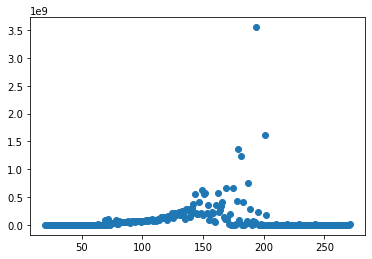

In [101]:
plt.scatter(times, avg_revenue)

In [108]:
import numpy as np
from matplotlib import pyplot as plt

x = np.array(times)
y = np.array(avg_revenue)
mymodel_avg = np.poly1d(np.polyfit(x, y, 6))

from sklearn.metrics import r2_score
print(r2_score(y, mymodel_avg(x)))

fig = plotCurve(x, y, mymodel_avg)
fig.show()

0.16936034748094242


In [105]:
import numpy as np
from matplotlib import pyplot as plt

x = np.array(runtime_arr)
y = np.array(revenue_arr)
mymodel = np.poly1d(np.polyfit(x, y, 6))

from sklearn.metrics import r2_score
print(r2_score(y, mymodel(x)))

fig = plotCurve(x, y, mymodel)
fig.show()

0.08614442432210179


In [112]:
revenue_arr = np.array(revenue_arr)
runtime_arr = np.array(runtime_arr)

fig = make_subplots()
fig.add_trace(
    go.Scatter(
        x=runtime_arr, 
        y=revenue_arr, 
        name="Data",
        mode='markers',
        line_color='rgba(153, 153, 255, .6)'
    ),
)

fig.add_trace(
    go.Scatter(
        x=times, 
        y=avg_revenue, 
        name="Averages",
        mode='markers',
        line_color='rgba(204, 0, 0, .6)'
    ),
)

myline = np.linspace(1, runtime_arr.max(), 100)
fig.add_trace(
    go.Scatter(
        x=myline, 
        y=mymodel(myline), 
        name="regression line",
        # mode='lines',
        # line_color='green'
        line=dict(color='green', width=3)
    ),
)

# myline = np.linspace(1, runtime_arr.max(), 100)
# fig.add_trace(
#     go.Scatter(
#         x=myline, 
#         y=mymodel_avg(myline), 
#         name="regression line",
#         # mode='lines',
#         # line_color='green'
#         line=dict(color='red', width=3)
#     ),
# )
